# Joint Distribution Construction and Synthetic Data Generation

This notebook constructs joint distributions for numerical variables within each categorical combination and generates synthetic datasets with pair plot comparisons.

## Workflow
1. **Load CSV data** with `cat_` and `num_` prefixed columns
2. **Group by categorical combinations** (e.g., cat_region + cat_segment)
3. **Construct joint distributions** for numerical variables in each group
4. **Generate synthetic data** of desired size preserving joint distributions
5. **Create pair plots** comparing original vs synthetic for each category combination

## Expected Data Format
```
cat_region, cat_type, num_sales, num_profit, num_customers
North,     Premium,   150.2,     45.6,      120
South,     Standard,  98.5,      22.3,      85
```

## Step 1: Setup and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal, gaussian_kde
from sklearn.preprocessing import StandardScaler
import warnings
import itertools
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
np.random.seed(42)

print("✅ Libraries imported successfully")
print("📊 Ready for joint distribution analysis")

# Global configuration
DESIRED_SYNTHETIC_SIZE = 1000  # Change this to your desired synthetic dataset size
GENERATION_METHOD = 'multivariate_normal'  # Options: 'multivariate_normal', 'kde', 'bootstrap'

print(f"Target synthetic dataset size: {DESIRED_SYNTHETIC_SIZE}")
print(f"Generation method: {GENERATION_METHOD}")

✅ Libraries imported successfully
📊 Ready for joint distribution analysis
Target synthetic dataset size: 1000
Generation method: multivariate_normal


## Step 2: Load Your CSV Data

**Important**: Update the file path below to your CSV file.

Your CSV should have:
- Categorical columns starting with `cat_`
- Numerical columns starting with `num_`

In [2]:
# CHANGE THIS PATH TO YOUR CSV FILE
CSV_FILE_PATH = 'your_data.csv'  # ← Update this with your file path

def load_data(file_path):
    """Load and validate CSV data"""
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Successfully loaded: {file_path}")
        print(f"Dataset shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"❌ File not found: {file_path}")
        print("Creating sample data for demonstration...")
        return create_sample_data()
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        print("Creating sample data for demonstration...")
        return create_sample_data()

def create_sample_data(n_samples=1200):
    """Create sample data for demonstration"""
    print("🎲 Creating sample business data...")
    
    # Categorical variables
    regions = ['North', 'South', 'East', 'West']
    segments = ['Enterprise', 'SMB', 'Consumer']
    
    cat_region = np.random.choice(regions, n_samples, p=[0.3, 0.25, 0.25, 0.2])
    cat_segment = np.random.choice(segments, n_samples, p=[0.2, 0.5, 0.3])
    
    # Initialize numerical arrays
    num_revenue = np.zeros(n_samples)
    num_profit = np.zeros(n_samples)
    num_customers = np.zeros(n_samples)
    num_satisfaction = np.zeros(n_samples)
    
    # Create different joint distributions for each combination
    for i in range(n_samples):
        region = cat_region[i]
        segment = cat_segment[i]
        
        # Region-based parameters
        region_multipliers = {
            'North': (1.2, 1.1),
            'South': (1.0, 1.0),
            'East': (1.1, 1.05),
            'West': (0.9, 0.95)
        }
        
        # Segment-based parameters
        segment_params = {
            'Enterprise': {'base_rev': 200, 'margin': 0.25, 'cust_base': 150, 'sat_base': 4.2},
            'SMB': {'base_rev': 100, 'margin': 0.15, 'cust_base': 80, 'sat_base': 3.8},
            'Consumer': {'base_rev': 50, 'margin': 0.10, 'cust_base': 200, 'sat_base': 3.5}
        }
        
        rev_mult, other_mult = region_multipliers[region]
        params = segment_params[segment]
        
        # Generate correlated variables
        base_revenue = params['base_rev'] * rev_mult
        base_customers = params['cust_base'] * other_mult
        
        # Create correlation between revenue and customers
        correlation = 0.7
        noise1 = np.random.normal(0, 1)
        noise2 = correlation * noise1 + np.sqrt(1 - correlation**2) * np.random.normal(0, 1)
        
        num_revenue[i] = base_revenue + 25 * noise1
        num_customers[i] = base_customers + 20 * noise2
        num_profit[i] = num_revenue[i] * params['margin'] + np.random.normal(0, 5)
        num_satisfaction[i] = params['sat_base'] + 0.3 * np.random.normal(0, 1)
        
        # Ensure positive values
        num_revenue[i] = max(10, num_revenue[i])
        num_customers[i] = max(5, num_customers[i])
        num_profit[i] = max(0, num_profit[i])
        num_satisfaction[i] = max(1, min(5, num_satisfaction[i]))
    
    df = pd.DataFrame({
        'cat_region': cat_region,
        'cat_segment': cat_segment,
        'num_revenue': num_revenue,
        'num_profit': num_profit,
        'num_customers': num_customers,
        'num_satisfaction': num_satisfaction
    })
    
    print(f"✅ Sample data created: {df.shape}")
    return df

# Load the data
df = load_data(CSV_FILE_PATH)

# Show basic info
print(f"\nDataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
df.head()

❌ File not found: your_data.csv
Creating sample data for demonstration...
🎲 Creating sample business data...
✅ Sample data created: (1200, 6)

Dataset Overview:
Shape: (1200, 6)
Columns: ['cat_region', 'cat_segment', 'num_revenue', 'num_profit', 'num_customers', 'num_satisfaction']

First 5 rows:


cat_region cat_segment  num_revenue  num_profit  num_customers  \
0      South    Consumer    35.945799    0.000000     189.141362   
1       West  Enterprise   204.121291   44.858578     179.083061   
2       East  Enterprise   219.339856   50.786946     161.131821   
3       East         SMB    98.154016   17.454524      77.159829   
4      North         SMB   109.090353   15.921738      80.325056   

   num_satisfaction  
0          3.258239  
1          4.022261  
2          4.327218  
3          3.801927  
4          3.688997

## Step 3: Data Validation and Analysis

In [3]:
# Identify column types
cat_cols = [col for col in df.columns if col.startswith('cat_')]
num_cols = [col for col in df.columns if col.startswith('num_')]

print(f"📊 DATA STRUCTURE ANALYSIS")
print(f"{'='*50}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numerical columns ({len(num_cols)}): {num_cols}")

if not cat_cols:
    print("❌ ERROR: No categorical columns found!")
    print("   Please ensure categorical columns start with 'cat_'")
elif not num_cols:
    print("❌ ERROR: No numerical columns found!")
    print("   Please ensure numerical columns start with 'num_'")
else:
    print("✅ Data structure is valid")

# Analyze categorical combinations
print(f"\n📈 CATEGORICAL COMBINATIONS ANALYSIS")
print(f"{'='*50}")

# Group by all categorical columns
grouped = df.groupby(cat_cols)
group_sizes = grouped.size().sort_values(ascending=False)

print(f"Total unique combinations: {len(group_sizes)}")
print(f"Average group size: {group_sizes.mean():.1f}")
print(f"Largest group: {group_sizes.max()} samples")
print(f"Smallest group: {group_sizes.min()} samples")

print(f"\nGroup sizes by combination:")
for combination, size in group_sizes.items():
    print(f"  {combination}: {size} samples")

# Statistical summary by group
print(f"\n📊 NUMERICAL STATISTICS BY GROUP")
print(f"{'='*50}")
group_stats = df.groupby(cat_cols)[num_cols].agg(['mean', 'std']).round(2)
print(group_stats)

📊 DATA STRUCTURE ANALYSIS
Categorical columns (2): ['cat_region', 'cat_segment']
Numerical columns (4): ['num_revenue', 'num_profit', 'num_customers', 'num_satisfaction']
✅ Data structure is valid

📈 CATEGORICAL COMBINATIONS ANALYSIS
Total unique combinations: 12
Average group size: 100.0
Largest group: 186 samples
Smallest group: 56 samples

Group sizes by combination:
  ('North', 'SMB'): 186 samples
  ('East', 'SMB'): 156 samples
  ('South', 'SMB'): 137 samples
  ('West', 'SMB'): 125 samples
  ('North', 'Consumer'): 118 samples
  ('East', 'Consumer'): 81 samples
  ('South', 'Consumer'): 78 samples
  ('North', 'Enterprise'): 72 samples
  ('West', 'Consumer'): 72 samples
  ('South', 'Enterprise'): 61 samples
  ('East', 'Enterprise'): 58 samples
  ('West', 'Enterprise'): 56 samples

📊 NUMERICAL STATISTICS BY GROUP
                       num_revenue        num_profit       num_customers  \
                              mean    std       mean   std          mean   
cat_region cat_segment 

## Step 4: Visualize Original Data

Creating pair plot for original data...


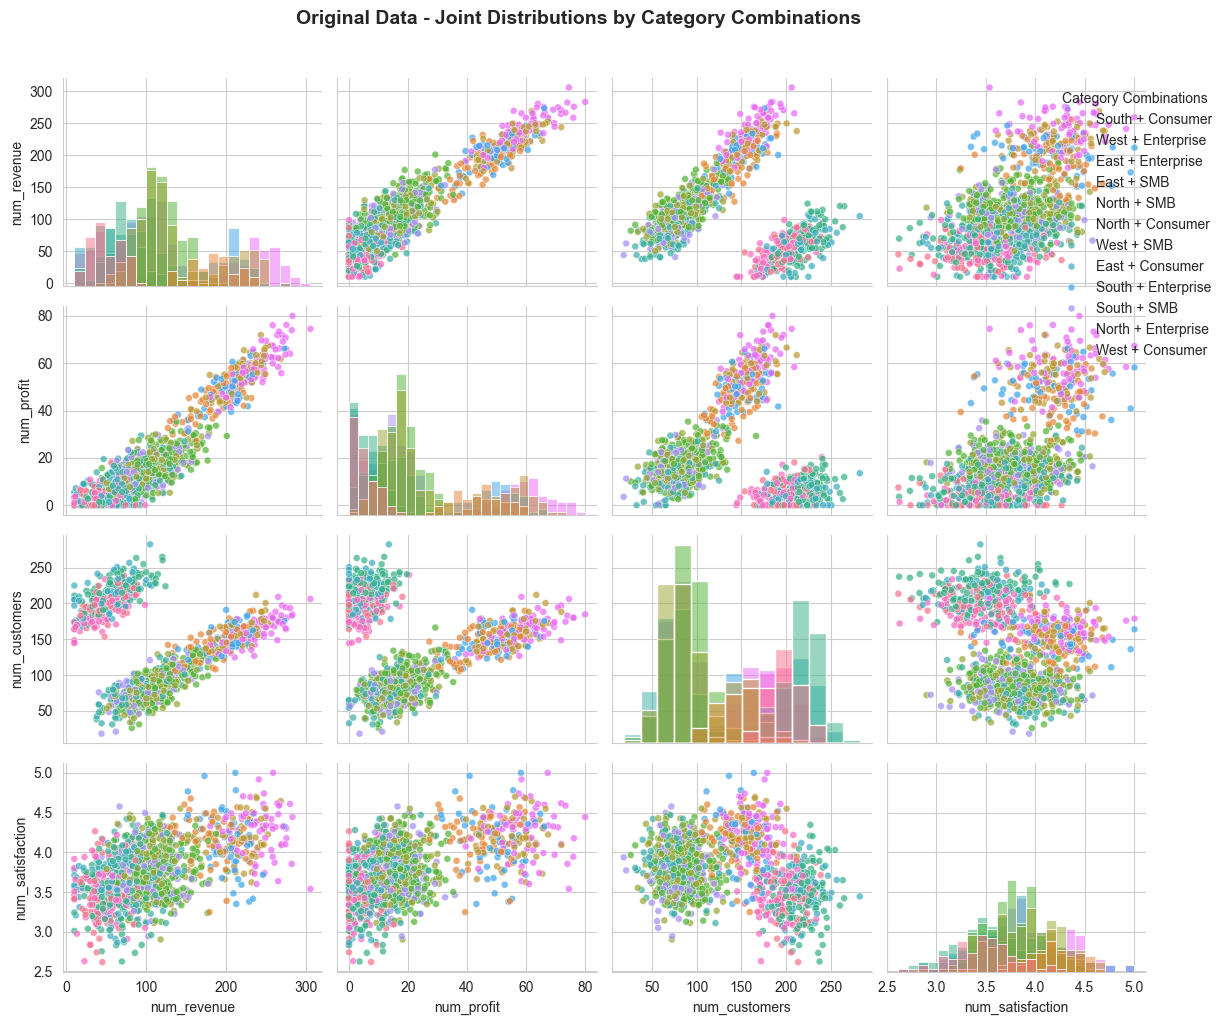

✅ Original data visualization complete
Each color represents a different combination of cat_region, cat_segment


In [4]:
# Create overall pair plot for original data
print("Creating pair plot for original data...")

# Create combined categorical column for coloring
df_plot = df.copy()
if len(cat_cols) == 1:
    df_plot['cat_combined'] = df_plot[cat_cols[0]]
else:
    df_plot['cat_combined'] = df_plot[cat_cols].apply(
        lambda x: ' + '.join(x.astype(str)), axis=1
    )

# Create pair plot
g = sns.pairplot(
    df_plot[num_cols + ['cat_combined']], 
    hue='cat_combined',
    diag_kind='hist',
    plot_kws={'alpha': 0.7, 's': 25},
    height=2.5
)

g.fig.suptitle('Original Data - Joint Distributions by Category Combinations', 
               y=1.02, fontsize=14, fontweight='bold')

# Improve legend
g._legend.set_title('Category Combinations')
g._legend.set_bbox_to_anchor((1.05, 0.8))

plt.tight_layout()
plt.show()

print("✅ Original data visualization complete")
print(f"Each color represents a different combination of {', '.join(cat_cols)}")

## Step 5: Joint Distribution Construction Framework

In [5]:
class JointDistributionSynthesizer:
    """
    Constructs joint distributions for each categorical combination
    and generates synthetic data preserving these relationships
    """
    
    def __init__(self, method='multivariate_normal', min_samples=5):
        self.method = method
        self.min_samples = min_samples
        self.distributions = {}
        self.cat_cols = None
        self.num_cols = None
        self.fitted = False
        
    def fit(self, df, cat_cols, num_cols):
        """Fit joint distributions for each categorical combination"""
        
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        
        print(f"🔧 FITTING JOINT DISTRIBUTIONS")
        print(f"{'='*50}")
        print(f"Method: {self.method}")
        print(f"Minimum samples per group: {self.min_samples}")
        
        grouped = df.groupby(cat_cols)
        successful_fits = 0
        
        for combination, group in grouped:
            group_size = len(group)
            
            if group_size < self.min_samples:
                print(f"  ⚠️  Skipping {combination}: only {group_size} samples")
                continue
            
            print(f"  🔄 Fitting {combination}: {group_size} samples")
            
            # Extract numerical data
            num_data = group[num_cols].values
            
            try:
                if self.method == 'multivariate_normal':
                    mean = np.mean(num_data, axis=0)
                    cov = np.cov(num_data.T)
                    
                    # Add small regularization to diagonal if needed
                    if len(num_cols) > 1:
                        cov += np.eye(len(num_cols)) * 1e-6
                    
                    # Test sampling
                    _ = multivariate_normal.rvs(mean=mean, cov=cov, size=2)
                    
                    self.distributions[combination] = {
                        'method': 'multivariate_normal',
                        'mean': mean,
                        'cov': cov,
                        'n_samples': group_size,
                        'original_data': num_data
                    }
                    
                elif self.method == 'kde':
                    if len(num_cols) == 1:
                        kde = gaussian_kde(num_data.T[0])
                    else:
                        kde = gaussian_kde(num_data.T)
                    
                    self.distributions[combination] = {
                        'method': 'kde',
                        'kde': kde,
                        'n_samples': group_size,
                        'original_data': num_data
                    }
                    
                elif self.method == 'bootstrap':
                    self.distributions[combination] = {
                        'method': 'bootstrap',
                        'n_samples': group_size,
                        'original_data': num_data
                    }
                
                successful_fits += 1
                print(f"    ✅ Success")
                
            except Exception as e:
                print(f"    ❌ Failed: {e}")
                print(f"    🔄 Falling back to bootstrap for this group")
                
                self.distributions[combination] = {
                    'method': 'bootstrap',
                    'n_samples': group_size,
                    'original_data': num_data
                }
                successful_fits += 1
        
        self.fitted = True
        print(f"\n✅ FITTING COMPLETE")
        print(f"Successfully fitted {successful_fits} distributions")
        print(f"Total combinations available: {len(self.distributions)}")
        
    def generate_synthetic(self, n_total, preserve_proportions=True, original_df=None):
        """Generate synthetic dataset of specified size"""
        
        if not self.fitted:
            raise ValueError("Model not fitted. Call fit() first.")
            
        print(f"🎲 GENERATING SYNTHETIC DATA")
        print(f"{'='*50}")
        print(f"Target total samples: {n_total}")
        print(f"Preserve proportions: {preserve_proportions}")
        
        synthetic_groups = []
        
        # Calculate sample sizes for each group
        if preserve_proportions and original_df is not None:
            total_original = len(original_df)
            proportions = {}
            for combination in self.distributions.keys():
                group_size = len(original_df.groupby(self.cat_cols).get_group(combination))
                proportions[combination] = group_size / total_original
        else:
            # Equal proportions
            n_groups = len(self.distributions)
            proportions = {combo: 1/n_groups for combo in self.distributions.keys()}
        
        for combination, dist_info in self.distributions.items():
            # Calculate samples for this combination
            n_samples = max(1, int(n_total * proportions[combination]))
            
            print(f"  🔄 Generating {n_samples} samples for {combination}")
            
            if dist_info['method'] == 'multivariate_normal':
                synthetic_num = multivariate_normal.rvs(
                    mean=dist_info['mean'],
                    cov=dist_info['cov'],
                    size=n_samples
                )
                if synthetic_num.ndim == 1:
                    synthetic_num = synthetic_num.reshape(-1, 1)
                    
            elif dist_info['method'] == 'kde':
                synthetic_num = dist_info['kde'].resample(n_samples).T
                
            elif dist_info['method'] == 'bootstrap':
                original_data = dist_info['original_data']
                indices = np.random.choice(len(original_data), size=n_samples, replace=True)
                synthetic_num = original_data[indices]
            
            # Create DataFrame for this group
            group_df = pd.DataFrame(synthetic_num, columns=self.num_cols)
            
            # Add categorical columns
            if isinstance(combination, tuple):
                for i, col in enumerate(self.cat_cols):
                    group_df[col] = combination[i]
            else:
                group_df[self.cat_cols[0]] = combination
            
            synthetic_groups.append(group_df)
        
        # Combine and shuffle
        synthetic_df = pd.concat(synthetic_groups, ignore_index=True)
        synthetic_df = synthetic_df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Reorder columns to match original
        column_order = self.cat_cols + self.num_cols
        synthetic_df = synthetic_df[column_order]
        
        print(f"\n✅ GENERATION COMPLETE")
        print(f"Generated {len(synthetic_df)} synthetic samples")
        
        return synthetic_df

print("✅ Joint Distribution Synthesizer class defined")

✅ Joint Distribution Synthesizer class defined


## Step 6: Construct Joint Distributions and Generate Synthetic Data

In [6]:
# Initialize and fit the synthesizer
synthesizer = JointDistributionSynthesizer(method=GENERATION_METHOD, min_samples=5)
synthesizer.fit(df, cat_cols, num_cols)

# Generate synthetic data
synthetic_df = synthesizer.generate_synthetic(
    n_total=DESIRED_SYNTHETIC_SIZE, 
    preserve_proportions=True, 
    original_df=df
)

print(f"\n📊 DATASET COMPARISON")
print(f"{'='*50}")
print(f"Original dataset: {df.shape}")
print(f"Synthetic dataset: {synthetic_df.shape}")

# Show sample of synthetic data
print(f"\nFirst 5 rows of synthetic data:")
synthetic_df.head()

🔧 FITTING JOINT DISTRIBUTIONS
Method: multivariate_normal
Minimum samples per group: 5
  🔄 Fitting ('East', 'Consumer'): 81 samples
    ✅ Success
  🔄 Fitting ('East', 'Enterprise'): 58 samples
    ✅ Success
  🔄 Fitting ('East', 'SMB'): 156 samples
    ✅ Success
  🔄 Fitting ('North', 'Consumer'): 118 samples
    ✅ Success
  🔄 Fitting ('North', 'Enterprise'): 72 samples
    ✅ Success
  🔄 Fitting ('North', 'SMB'): 186 samples
    ✅ Success
  🔄 Fitting ('South', 'Consumer'): 78 samples
    ✅ Success
  🔄 Fitting ('South', 'Enterprise'): 61 samples
    ✅ Success
  🔄 Fitting ('South', 'SMB'): 137 samples
    ✅ Success
  🔄 Fitting ('West', 'Consumer'): 72 samples
    ✅ Success
  🔄 Fitting ('West', 'Enterprise'): 56 samples
    ✅ Success
  🔄 Fitting ('West', 'SMB'): 125 samples
    ✅ Success

✅ FITTING COMPLETE
Successfully fitted 12 distributions
Total combinations available: 12
🎲 GENERATING SYNTHETIC DATA
Target total samples: 1000
Preserve proportions: True
  🔄 Generating 67 samples for ('Ea

cat_region cat_segment  num_revenue  num_profit  num_customers  \
0      North         SMB   123.970298    8.999627      98.822899   
1       West    Consumer    70.813532   14.438734     184.838569   
2       East         SMB   117.653191   16.498967      86.705409   
3      North    Consumer    63.246758    7.769565     234.813325   
4      South         SMB   117.302028   10.990930      84.127622   

   num_satisfaction  
0          3.178245  
1          4.054639  
2          2.693997  
3          3.682800  
4          4.087084

## Step 7: Statistical Comparison

In [7]:
def compare_datasets(original_df, synthetic_df, cat_cols, num_cols):
    """Comprehensive statistical comparison between datasets"""
    
    print(f"📈 STATISTICAL COMPARISON")
    print(f"{'='*60}")
    
    # Overall statistics
    print(f"\n1. OVERALL STATISTICS")
    print(f"{'-'*30}")
    
    orig_overall = original_df[num_cols].describe()
    synth_overall = synthetic_df[num_cols].describe()
    
    for col in num_cols:
        orig_mean = orig_overall.loc['mean', col]
        synth_mean = synth_overall.loc['mean', col]
        orig_std = orig_overall.loc['std', col]
        synth_std = synth_overall.loc['std', col]
        
        print(f"{col}:")
        print(f"  Original  - Mean: {orig_mean:.2f}, Std: {orig_std:.2f}")
        print(f"  Synthetic - Mean: {synth_mean:.2f}, Std: {synth_std:.2f}")
        print(f"  Difference - Mean: {abs(orig_mean - synth_mean):.2f}, Std: {abs(orig_std - synth_std):.2f}")
        print()
    
    # Group-wise comparison
    print(f"2. GROUP-WISE COMPARISON")
    print(f"{'-'*30}")
    
    orig_grouped = original_df.groupby(cat_cols)[num_cols].agg(['mean', 'std'])
    synth_grouped = synthetic_df.groupby(cat_cols)[num_cols].agg(['mean', 'std'])
    
    print("Group means comparison:")
    means_comparison = pd.DataFrame()
    for col in num_cols:
        means_comparison[f'{col}_orig'] = orig_grouped[col]['mean']
        means_comparison[f'{col}_synth'] = synth_grouped[col]['mean']
        means_comparison[f'{col}_diff'] = abs(orig_grouped[col]['mean'] - synth_grouped[col]['mean'])
    
    print(means_comparison.round(2))
    
    # Correlation comparison
    print(f"\n3. CORRELATION MATRICES")
    print(f"{'-'*30}")
    
    orig_corr = original_df[num_cols].corr()
    synth_corr = synthetic_df[num_cols].corr()
    
    print("Original correlations:")
    print(orig_corr.round(3))
    print("\nSynthetic correlations:")
    print(synth_corr.round(3))
    print("\nCorrelation differences:")
    print((synth_corr - orig_corr).round(3))
    
    return means_comparison

# Perform comparison
comparison_results = compare_datasets(df, synthetic_df, cat_cols, num_cols)

📈 STATISTICAL COMPARISON

1. OVERALL STATISTICS
------------------------------
num_revenue:
  Original  - Mean: 113.59, Std: 62.00
  Synthetic - Mean: 113.61, Std: 61.86
  Difference - Mean: 0.02, Std: 0.14

num_profit:
  Original  - Mean: 20.40, Std: 18.31
  Synthetic - Mean: 20.28, Std: 18.08
  Difference - Mean: 0.12, Std: 0.23

num_customers:
  Original  - Mean: 133.37, Std: 58.78
  Synthetic - Mean: 133.16, Std: 59.73
  Difference - Mean: 0.22, Std: 0.95

num_satisfaction:
  Original  - Mean: 3.79, Std: 0.39
  Synthetic - Mean: 3.80, Std: 0.38
  Difference - Mean: 0.01, Std: 0.00

2. GROUP-WISE COMPARISON
------------------------------
Group means comparison:
                        num_revenue_orig  num_revenue_synth  num_revenue_diff  \
cat_region cat_segment                                                          
East       Consumer                56.84              57.27              0.43   
           Enterprise             218.05             216.50              1.54   
   

In [8]:
comparison_results

num_revenue_orig  num_revenue_synth  num_revenue_diff  \
cat_region cat_segment                                                          
East       Consumer            56.844306          57.271389          0.427083   
           Enterprise         218.045624         216.501531          1.544093   
           SMB                108.631630         109.385339          0.753709   
North      Consumer            62.307986          65.185608          2.877622   
           Enterprise         241.673271         244.363751          2.690479   
           SMB                119.401205         117.896397          1.504808   
South      Consumer            50.057451          49.782560          0.274891   
           Enterprise         203.188318         200.652097          2.536221   
           SMB                102.801387         104.599302          1.797915   
West       Consumer            46.920773          47.900268          0.979494   
           Enterprise         183.135960         178.642983          4.492977   
           SMB                 89.030551          88.569214          0.461337   

                        num_profit_orig  num_profit_synth  num_profit_diff  \
cat_region cat_segment                                                       
East       Consumer            4.966931          5.312165         0.345233   
           Enterprise         54.733633         53.880600         0.853033   
           SMB                16.419651         16.207585         0.212066   
North      Consumer            6.487977          7.236163         0.748186   
           Enterprise         59.489544         59.436781         0.052763   
           SMB                17.976116         17.588800         0.387316   
South      Consumer            4.900130          4.746011         0.154119   
           Enterprise         49.617320         49.077889         0.539431   
           SMB                15.656248         15.776486         0.120238   
West       Consumer            4.687910          4.685547         0.002363   
           Enterprise         44.243344         43.195705         1.047639   
           SMB                12.684318         12.915523         0.231205   

                        num_customers_orig  num_customers_synth  \
cat_region cat_segment                                            
East       Consumer             212.667871           211.804865   
           Enterprise           157.070375           154.549485   
           SMB                   80.812071            79.581477   
North      Consumer             219.225334           221.610888   
           Enterprise           164.208905           166.688909   
           SMB                   88.615257            87.284827   
South      Consumer             199.292927           198.966378   
           Enterprise           151.809379           152.661848   
           SMB                   80.274465            81.957698   
West       Consumer             189.665988           193.155049   
           Enterprise           142.952842           139.064698   
           SMB                   75.748872            73.633304   

                        num_customers_diff  num_satisfaction_orig  \
cat_region cat_segment                                              
East       Consumer               0.863006               3.496684   
           Enterprise             2.520891               4.183354   
           SMB                    1.230594               3.865371   
North      Consumer               2.385554               3.474456   
           Enterprise             2.480005               4.260915   
           SMB                    1.330430               3.789800   
South      Consumer               0.326550               3.477249   
           Enterprise             0.852470               4.136582   
           SMB                    1.683233               3.778090   
West       Consumer               3.489061               3.491871   
           Enterprise        

## Step 8: Overall Pair Plot Comparison

Creating overall pair plot comparison...


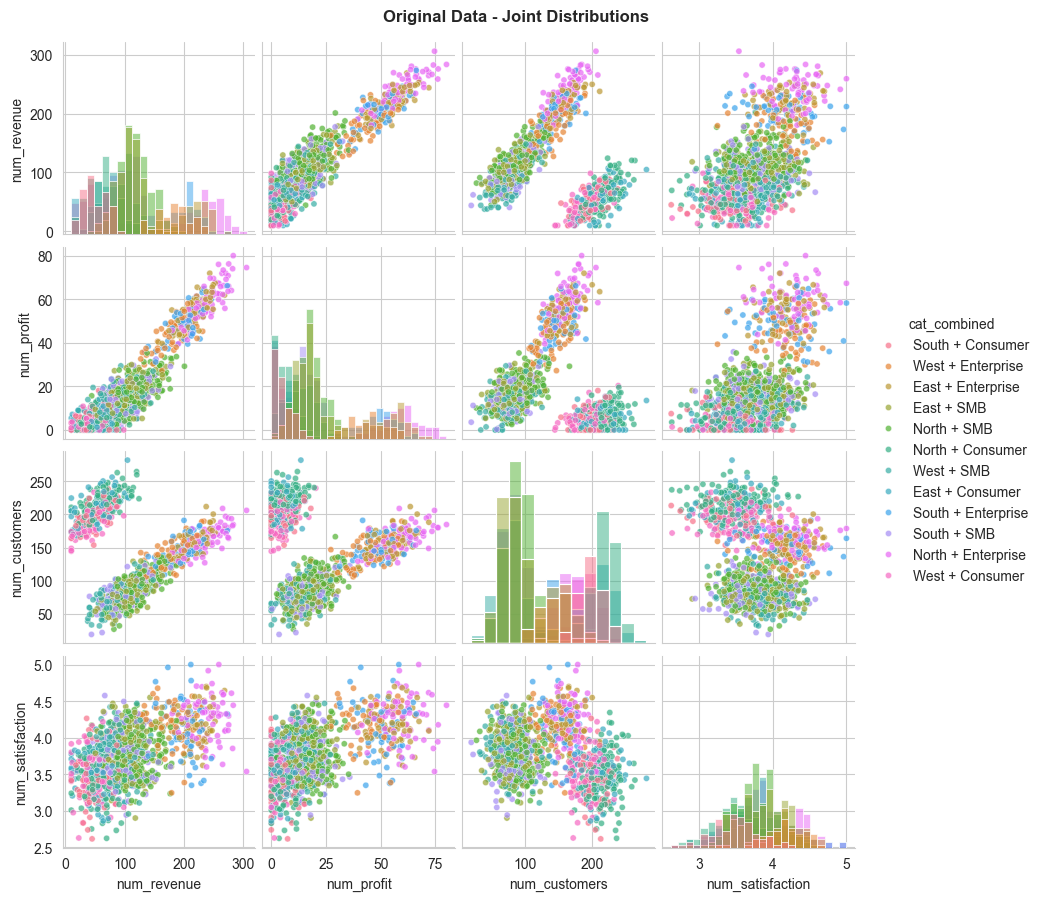

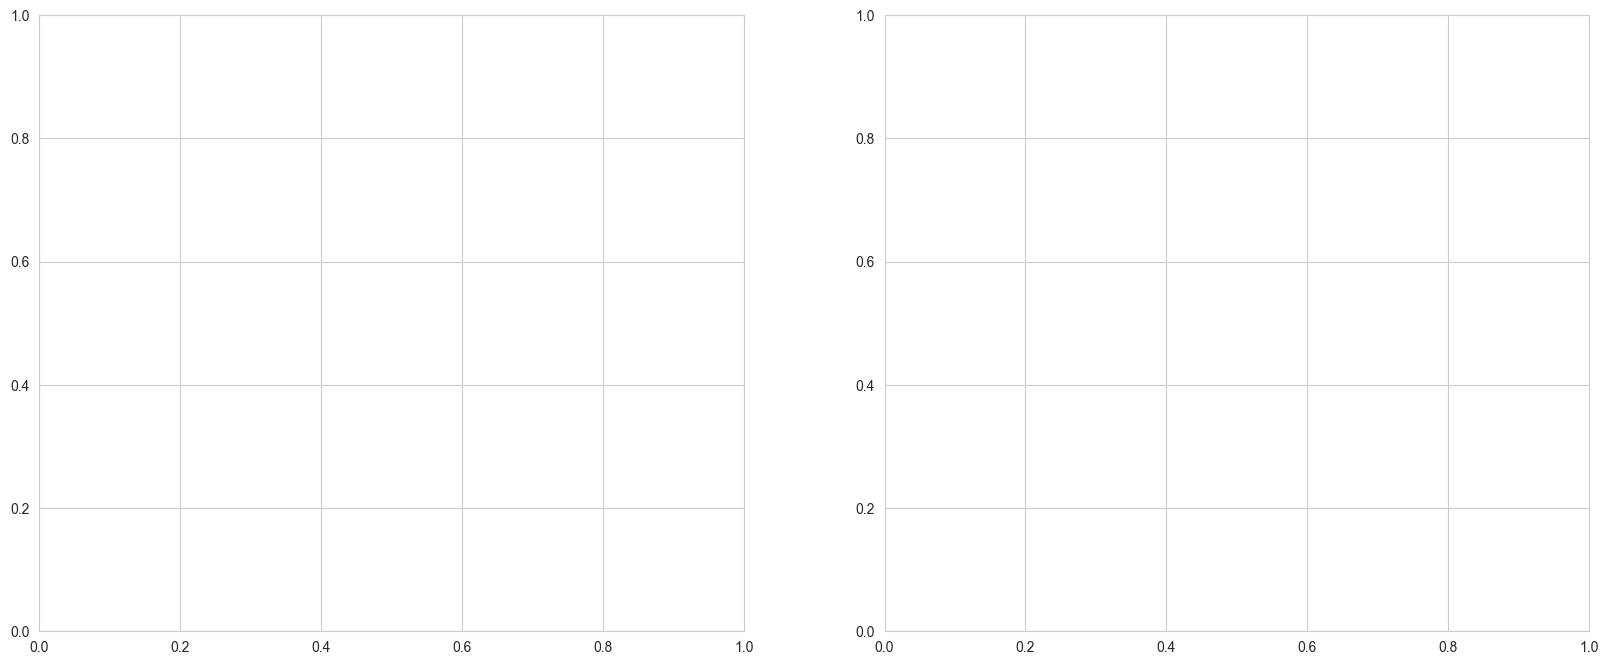

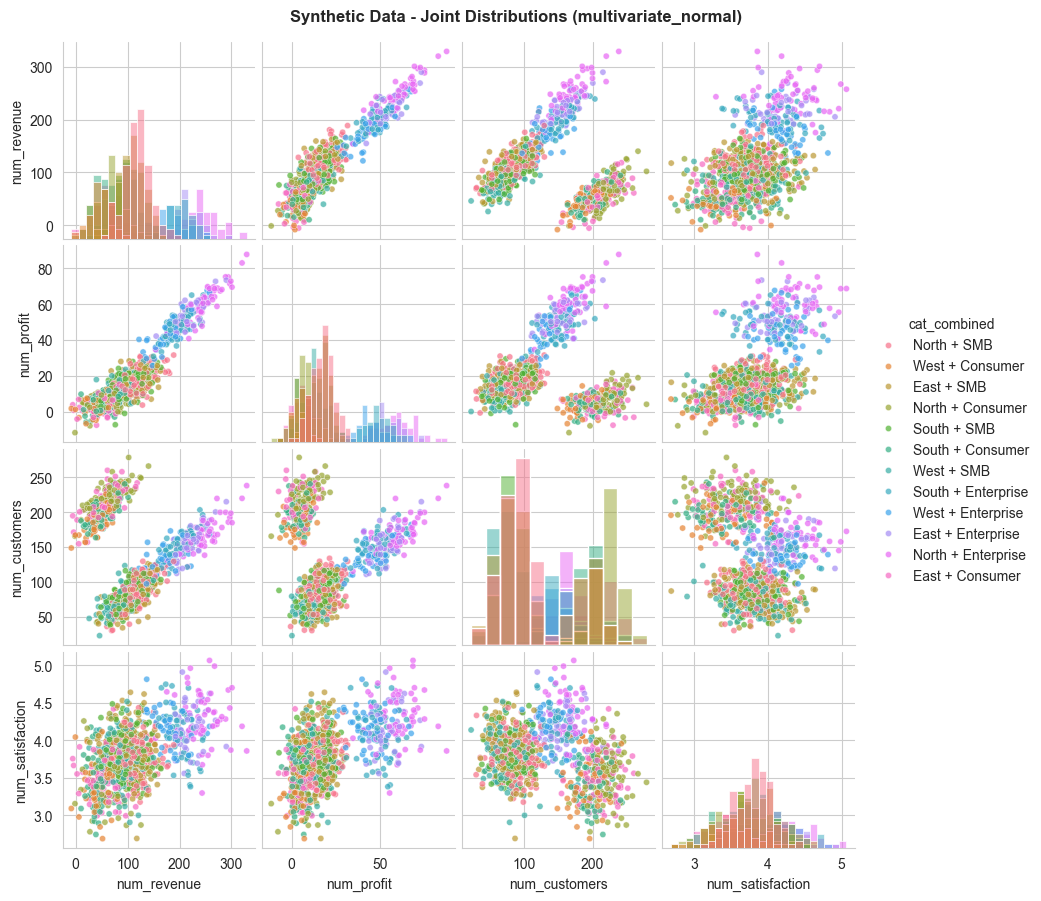

✅ Overall comparison complete


In [9]:
# Create overall comparison pair plot
print("Creating overall pair plot comparison...")

# Prepare data for plotting
orig_plot = df.copy()
orig_plot['Dataset'] = 'Original'
if len(cat_cols) == 1:
    orig_plot['cat_combined'] = orig_plot[cat_cols[0]]
else:
    orig_plot['cat_combined'] = orig_plot[cat_cols].apply(
        lambda x: ' + '.join(x.astype(str)), axis=1
    )

synth_plot = synthetic_df.copy()
synth_plot['Dataset'] = 'Synthetic'
if len(cat_cols) == 1:
    synth_plot['cat_combined'] = synth_plot[cat_cols[0]]
else:
    synth_plot['cat_combined'] = synth_plot[cat_cols].apply(
        lambda x: ' + '.join(x.astype(str)), axis=1
    )

# Create side-by-side pair plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Original data pair plot
plt.sca(ax1)
g1 = sns.pairplot(
    orig_plot[num_cols + ['cat_combined']], 
    hue='cat_combined',
    diag_kind='hist',
    plot_kws={'alpha': 0.7, 's': 20},
    height=2.2
)
g1.fig.suptitle('Original Data - Joint Distributions', y=1.02, fontweight='bold')

# Synthetic data pair plot
plt.sca(ax2)
g2 = sns.pairplot(
    synth_plot[num_cols + ['cat_combined']], 
    hue='cat_combined',
    diag_kind='hist',
    plot_kws={'alpha': 0.7, 's': 20},
    height=2.2
)
g2.fig.suptitle(f'Synthetic Data - Joint Distributions ({GENERATION_METHOD})', y=1.02, fontweight='bold')

plt.show()

print("✅ Overall comparison complete")

## Step 9: Category-wise Pair Plot Comparisons

**This is the key analysis**: Individual pair plots for each categorical combination showing original vs synthetic data side-by-side.

🎨 CREATING CATEGORY-WISE PAIR PLOTS

📊 Creating pair plot 1/12: ('East', 'Consumer')
  Original samples: 81, Synthetic samples: 67


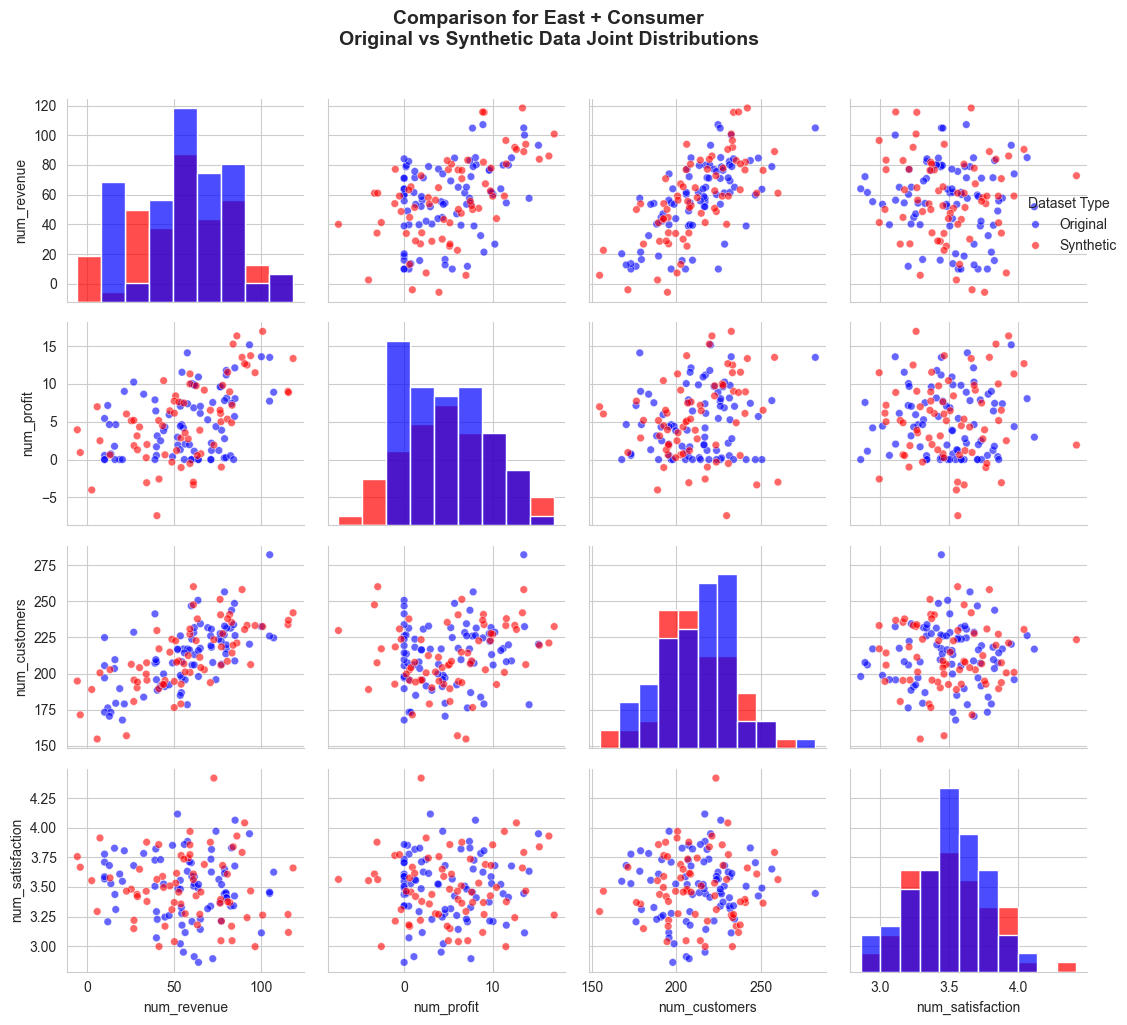

  📈 Statistics for East + Consumer:
    num_revenue: Orig(μ=56.84, σ=24.89) vs Synth(μ=57.27, σ=28.44)
    num_profit: Orig(μ=4.97, σ=4.27) vs Synth(μ=5.31, σ=5.32)
    num_customers: Orig(μ=212.67, σ=21.63) vs Synth(μ=211.80, σ=22.53)
    num_satisfaction: Orig(μ=3.50, σ=0.27) vs Synth(μ=3.50, σ=0.29)
    Correlation preservation quality:
    Average correlation difference: 0.064
  ✅ Completed pair plot for East + Consumer

📊 Creating pair plot 2/12: ('East', 'Enterprise')
  Original samples: 58, Synthetic samples: 48


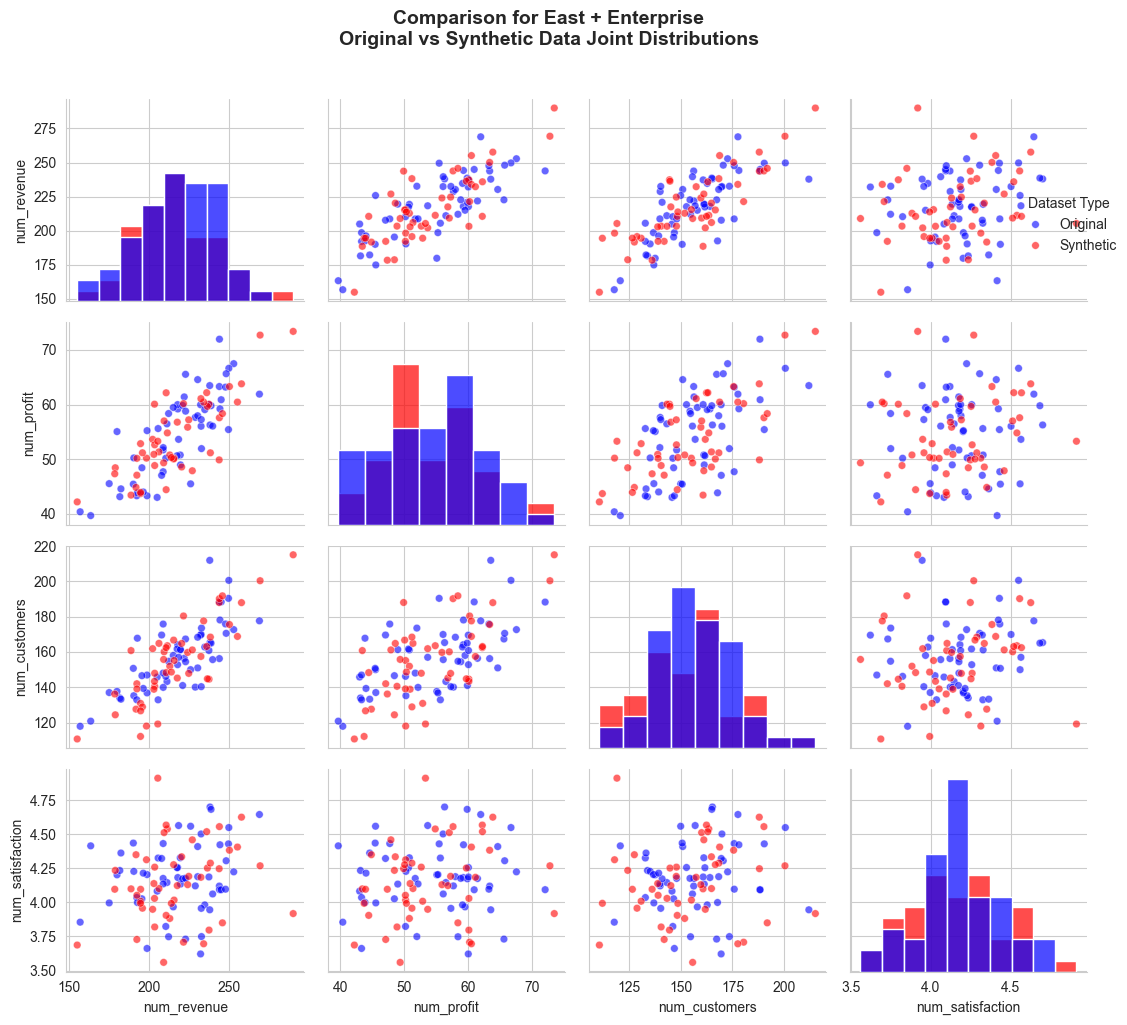

  📈 Statistics for East + Enterprise:
    num_revenue: Orig(μ=218.05, σ=23.75) vs Synth(μ=216.50, σ=25.34)
    num_profit: Orig(μ=54.73, σ=7.73) vs Synth(μ=53.88, σ=7.13)
    num_customers: Orig(μ=157.07, σ=18.95) vs Synth(μ=154.55, σ=23.15)
    num_satisfaction: Orig(μ=4.18, σ=0.25) vs Synth(μ=4.15, σ=0.29)
    Correlation preservation quality:
    Average correlation difference: 0.059
  ✅ Completed pair plot for East + Enterprise

📊 Creating pair plot 3/12: ('East', 'SMB')
  Original samples: 156, Synthetic samples: 130


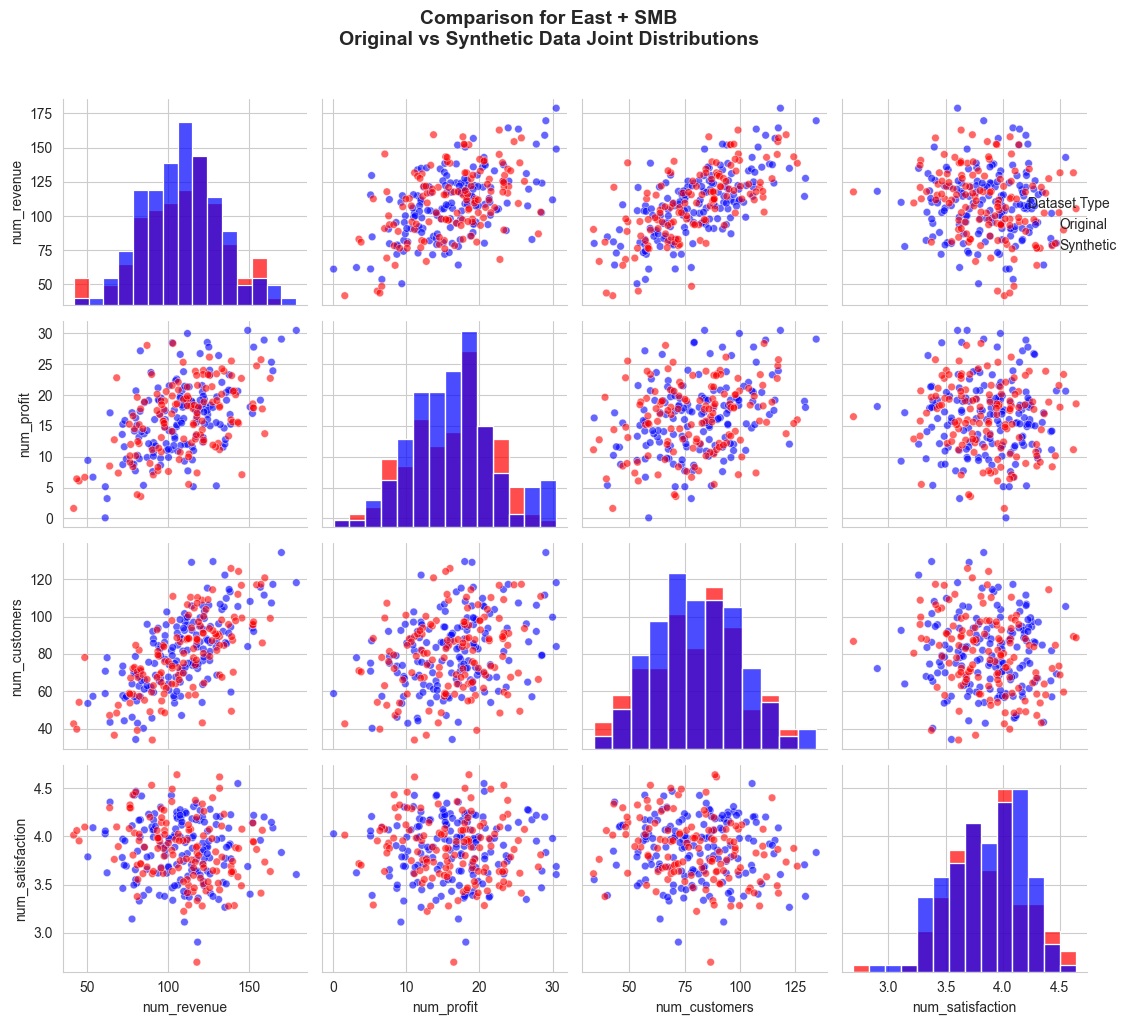

  📈 Statistics for East + SMB:
    num_revenue: Orig(μ=108.63, σ=23.75) vs Synth(μ=109.39, σ=25.28)
    num_profit: Orig(μ=16.42, σ=5.88) vs Synth(μ=16.21, σ=5.68)
    num_customers: Orig(μ=80.81, σ=19.68) vs Synth(μ=79.58, σ=20.41)
    num_satisfaction: Orig(μ=3.87, σ=0.32) vs Synth(μ=3.86, σ=0.33)
    Correlation preservation quality:
    Average correlation difference: 0.134
  ✅ Completed pair plot for East + SMB

📊 Creating pair plot 4/12: ('North', 'Consumer')
  Original samples: 118, Synthetic samples: 98


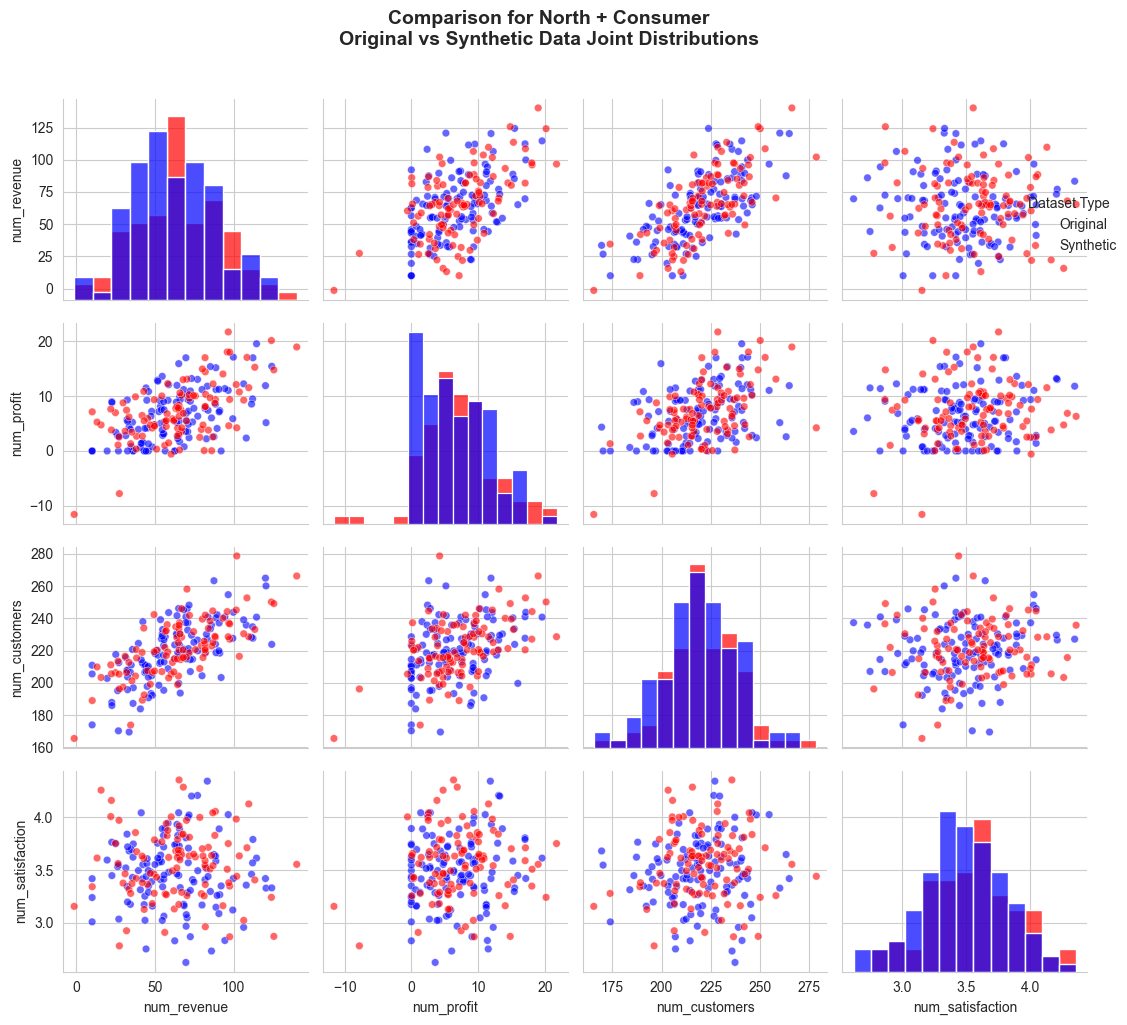

  📈 Statistics for North + Consumer:
    num_revenue: Orig(μ=62.31, σ=25.52) vs Synth(μ=65.19, σ=27.30)
    num_profit: Orig(μ=6.49, σ=4.84) vs Synth(μ=7.24, σ=5.45)
    num_customers: Orig(μ=219.23, σ=18.65) vs Synth(μ=221.61, σ=18.15)
    num_satisfaction: Orig(μ=3.47, σ=0.33) vs Synth(μ=3.56, σ=0.33)
    Correlation preservation quality:
    Average correlation difference: 0.070
  ✅ Completed pair plot for North + Consumer

📊 Creating pair plot 5/12: ('North', 'Enterprise')
  Original samples: 72, Synthetic samples: 60


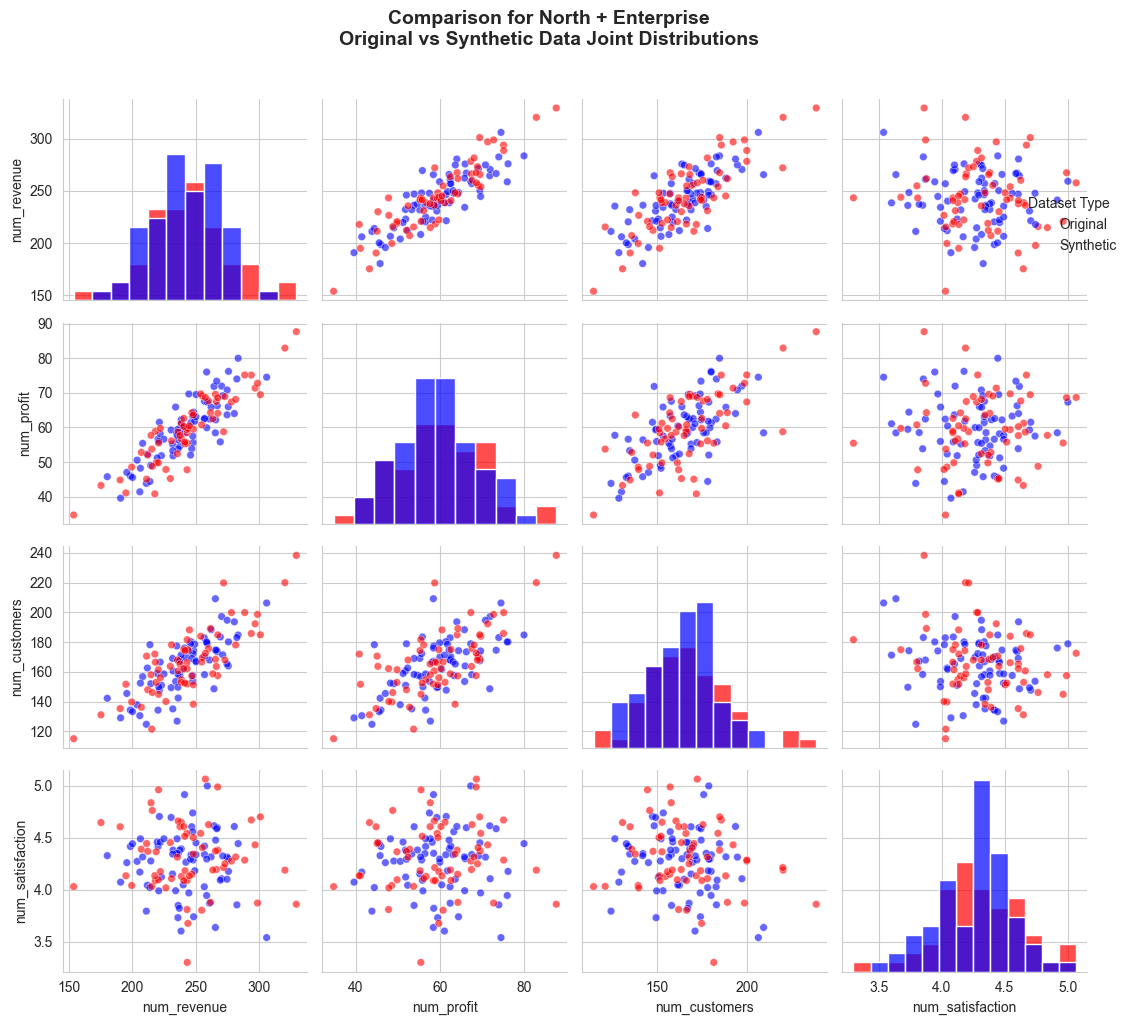

  📈 Statistics for North + Enterprise:
    num_revenue: Orig(μ=241.67, σ=25.36) vs Synth(μ=244.36, σ=33.15)
    num_profit: Orig(μ=59.49, σ=8.85) vs Synth(μ=59.44, σ=10.38)
    num_customers: Orig(μ=164.21, σ=18.67) vs Synth(μ=166.69, σ=22.96)
    num_satisfaction: Orig(μ=4.26, σ=0.30) vs Synth(μ=4.31, σ=0.33)
    Correlation preservation quality:
    Average correlation difference: 0.050
  ✅ Completed pair plot for North + Enterprise

📊 Creating pair plot 6/12: ('North', 'SMB')
  Original samples: 186, Synthetic samples: 155


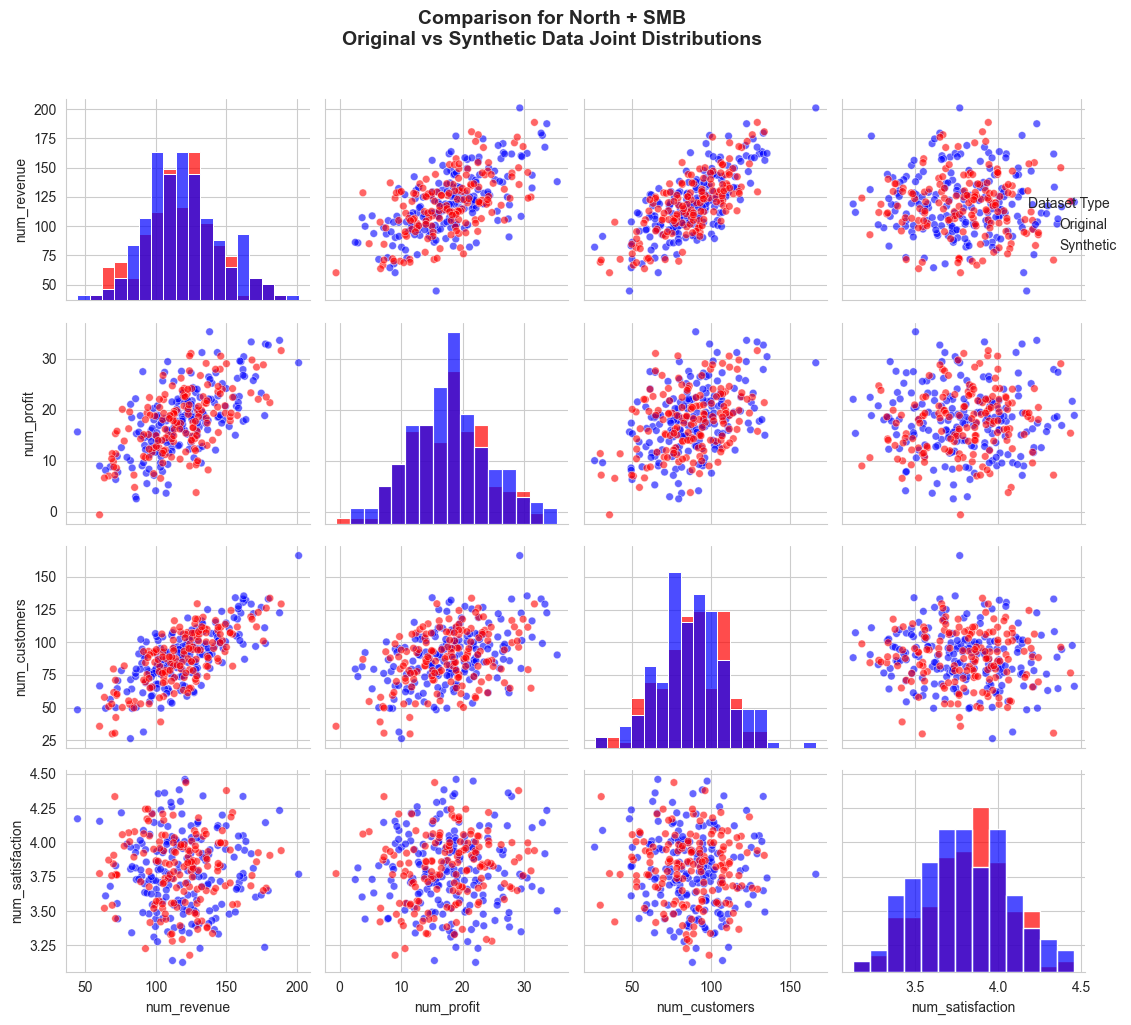

  📈 Statistics for North + SMB:
    num_revenue: Orig(μ=119.40, σ=26.60) vs Synth(μ=117.90, σ=25.70)
    num_profit: Orig(μ=17.98, σ=6.56) vs Synth(μ=17.59, σ=6.20)
    num_customers: Orig(μ=88.62, σ=21.56) vs Synth(μ=87.28, σ=21.43)
    num_satisfaction: Orig(μ=3.79, σ=0.28) vs Synth(μ=3.80, σ=0.25)
    Correlation preservation quality:
    Average correlation difference: 0.056
  ✅ Completed pair plot for North + SMB

📊 Creating pair plot 7/12: ('South', 'Consumer')
  Original samples: 78, Synthetic samples: 65


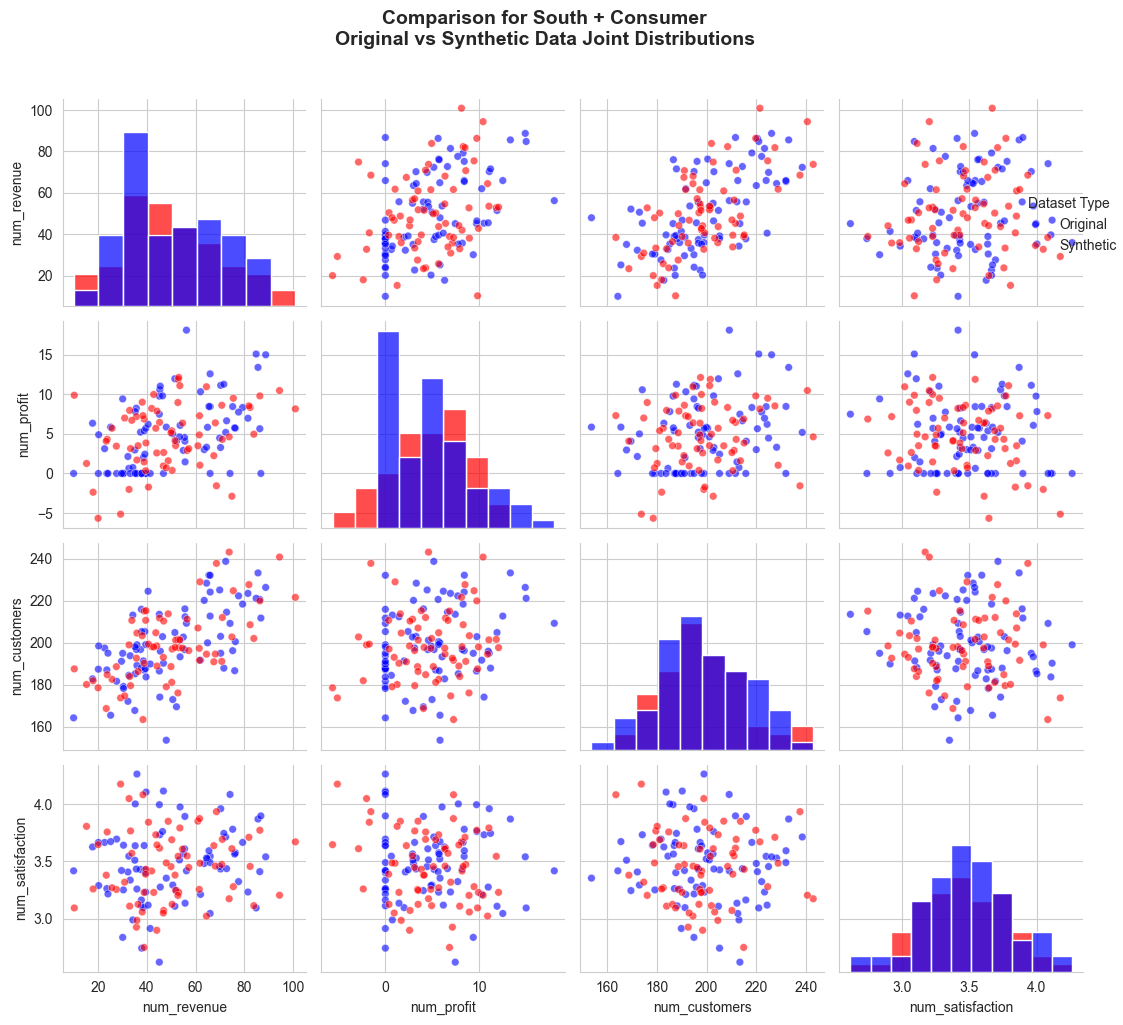

  📈 Statistics for South + Consumer:
    num_revenue: Orig(μ=50.06, σ=19.63) vs Synth(μ=49.78, σ=19.55)
    num_profit: Orig(μ=4.90, σ=4.45) vs Synth(μ=4.75, σ=4.11)
    num_customers: Orig(μ=199.29, σ=18.19) vs Synth(μ=198.97, σ=16.86)
    num_satisfaction: Orig(μ=3.48, σ=0.32) vs Synth(μ=3.45, σ=0.32)
    Correlation preservation quality:
    Average correlation difference: 0.112
  ✅ Completed pair plot for South + Consumer

📊 Creating pair plot 8/12: ('South', 'Enterprise')
  Original samples: 61, Synthetic samples: 50


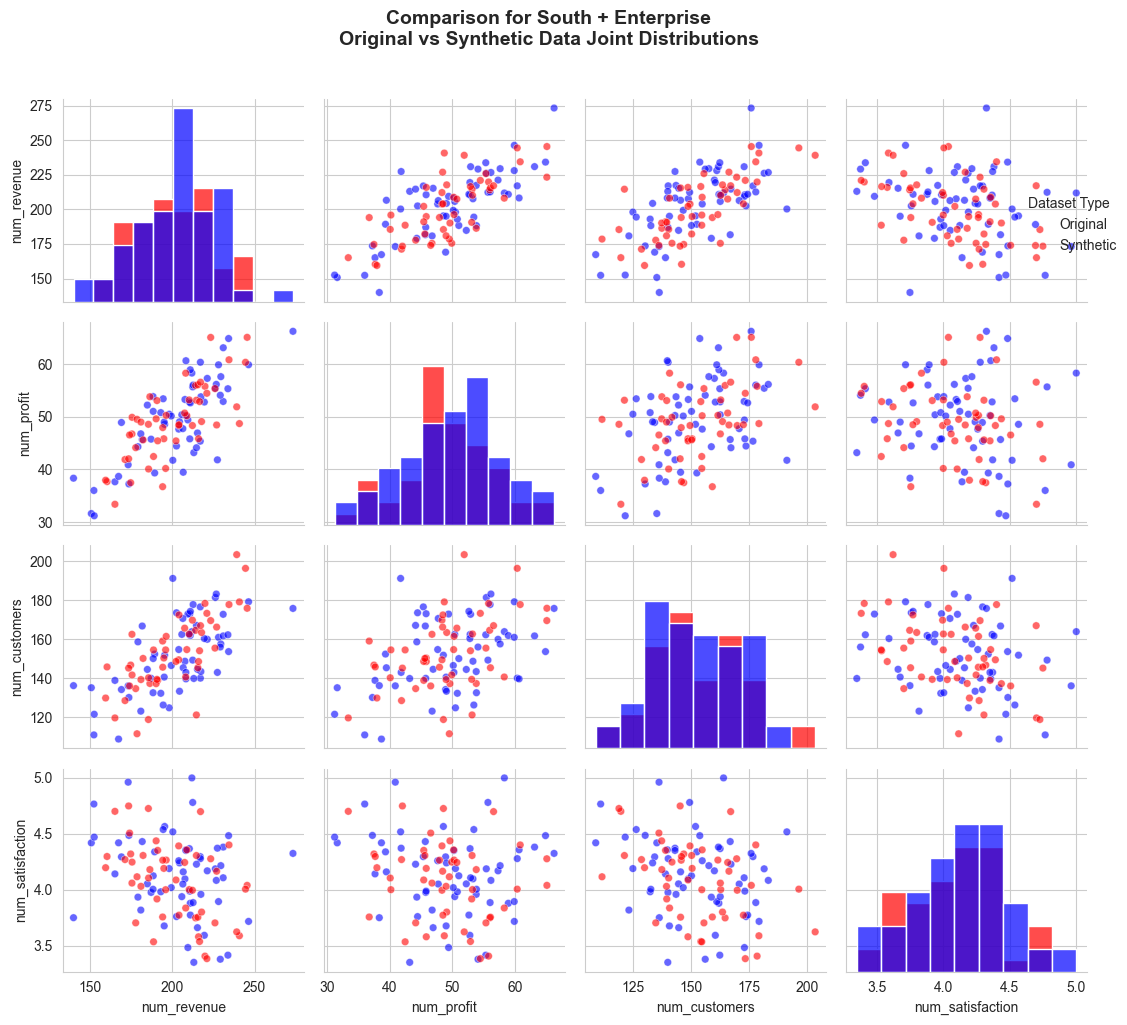

  📈 Statistics for South + Enterprise:
    num_revenue: Orig(μ=203.19, σ=24.76) vs Synth(μ=200.65, σ=22.47)
    num_profit: Orig(μ=49.62, σ=7.91) vs Synth(μ=49.08, σ=7.02)
    num_customers: Orig(μ=151.81, σ=18.56) vs Synth(μ=152.66, σ=19.09)
    num_satisfaction: Orig(μ=4.14, σ=0.36) vs Synth(μ=4.08, σ=0.35)
    Correlation preservation quality:
    Average correlation difference: 0.112
  ✅ Completed pair plot for South + Enterprise

📊 Creating pair plot 9/12: ('South', 'SMB')
  Original samples: 137, Synthetic samples: 114


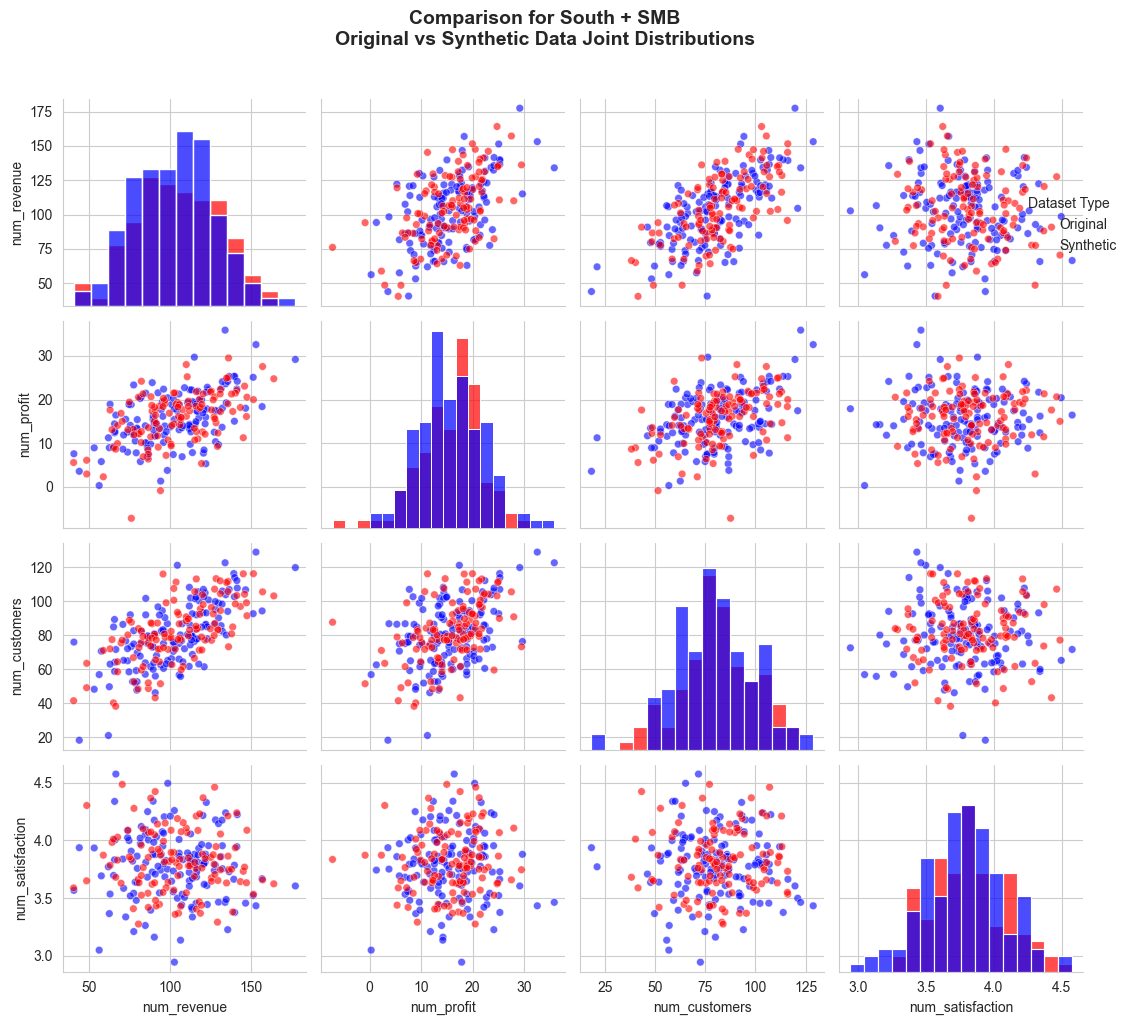

  📈 Statistics for South + SMB:
    num_revenue: Orig(μ=102.80, σ=24.99) vs Synth(μ=104.60, σ=25.33)
    num_profit: Orig(μ=15.66, σ=6.13) vs Synth(μ=15.78, σ=6.05)
    num_customers: Orig(μ=80.27, σ=19.12) vs Synth(μ=81.96, σ=17.89)
    num_satisfaction: Orig(μ=3.78, σ=0.29) vs Synth(μ=3.82, σ=0.27)
    Correlation preservation quality:
    Average correlation difference: 0.026
  ✅ Completed pair plot for South + SMB

📊 Creating pair plot 10/12: ('West', 'Consumer')
  Original samples: 72, Synthetic samples: 60


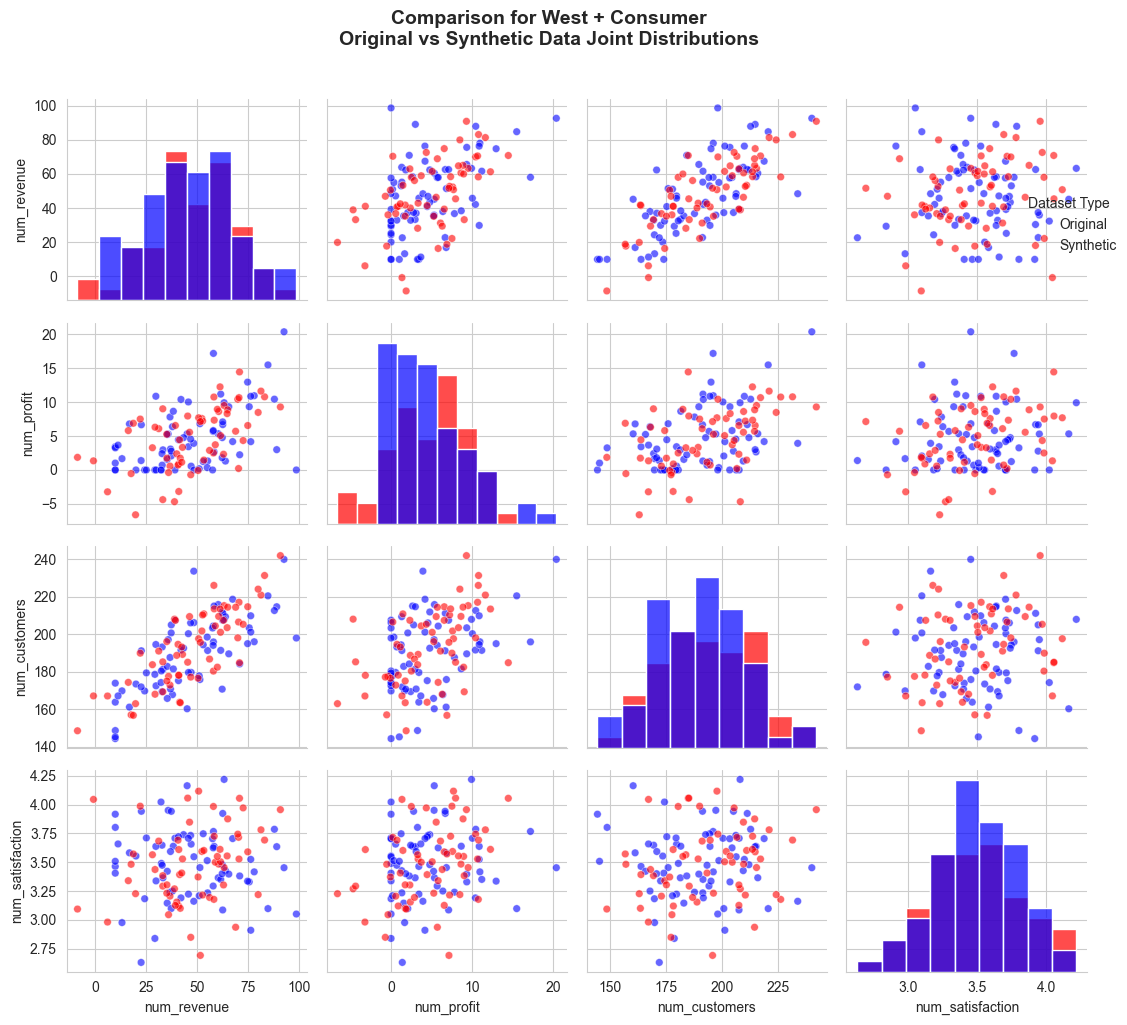

  📈 Statistics for West + Consumer:
    num_revenue: Orig(μ=46.92, σ=21.86) vs Synth(μ=47.90, σ=20.72)
    num_profit: Orig(μ=4.69, σ=4.51) vs Synth(μ=4.69, σ=4.57)
    num_customers: Orig(μ=189.67, σ=19.75) vs Synth(μ=193.16, σ=20.66)
    num_satisfaction: Orig(μ=3.49, σ=0.30) vs Synth(μ=3.48, σ=0.33)
    Correlation preservation quality:
    Average correlation difference: 0.189
  ✅ Completed pair plot for West + Consumer

📊 Creating pair plot 11/12: ('West', 'Enterprise')
  Original samples: 56, Synthetic samples: 46


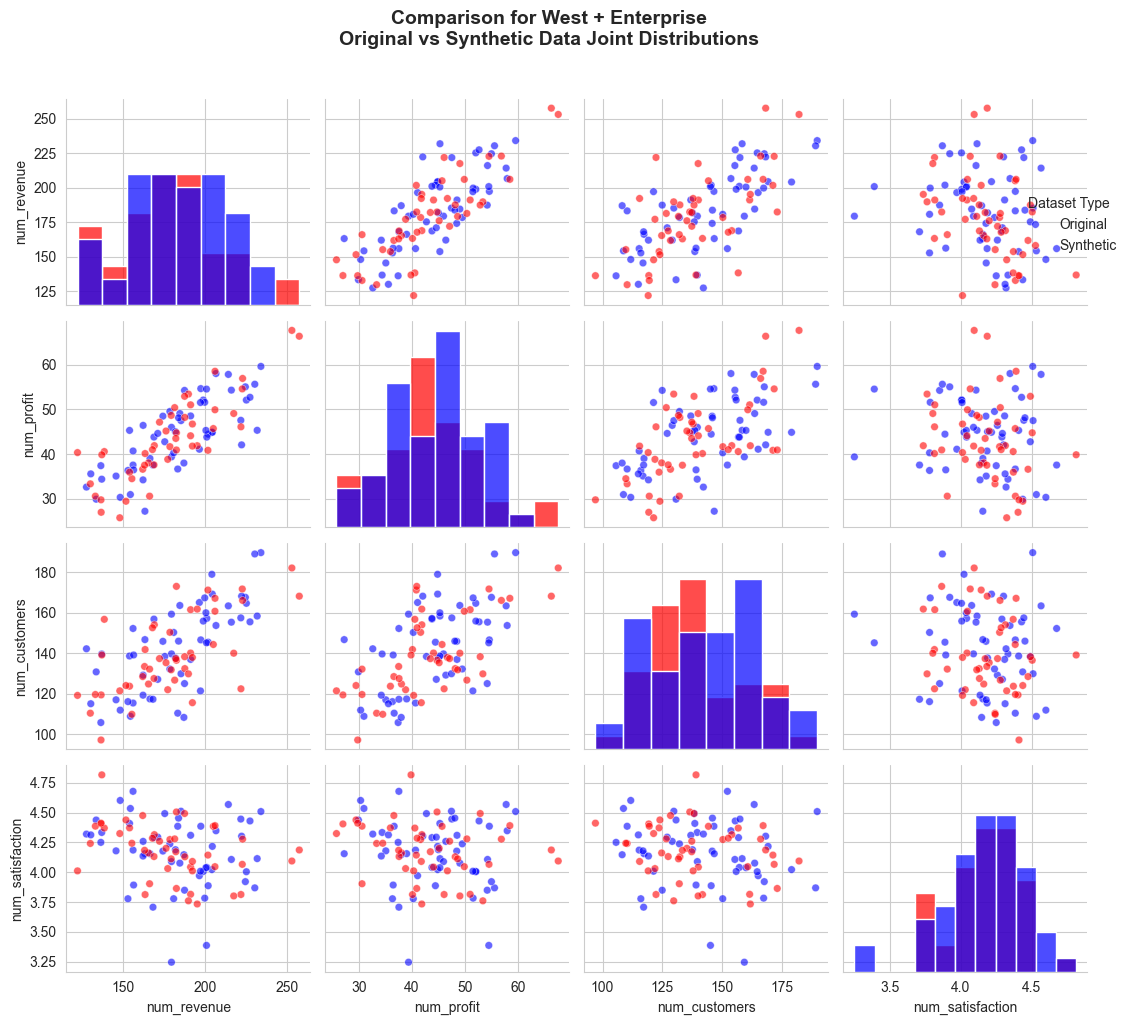

  📈 Statistics for West + Enterprise:
    num_revenue: Orig(μ=183.14, σ=28.37) vs Synth(μ=178.64, σ=30.57)
    num_profit: Orig(μ=44.24, σ=7.99) vs Synth(μ=43.20, σ=9.27)
    num_customers: Orig(μ=142.95, σ=21.16) vs Synth(μ=139.06, σ=19.61)
    num_satisfaction: Orig(μ=4.16, σ=0.28) vs Synth(μ=4.18, σ=0.23)
    Correlation preservation quality:
    Average correlation difference: 0.098
  ✅ Completed pair plot for West + Enterprise

📊 Creating pair plot 12/12: ('West', 'SMB')
  Original samples: 125, Synthetic samples: 104


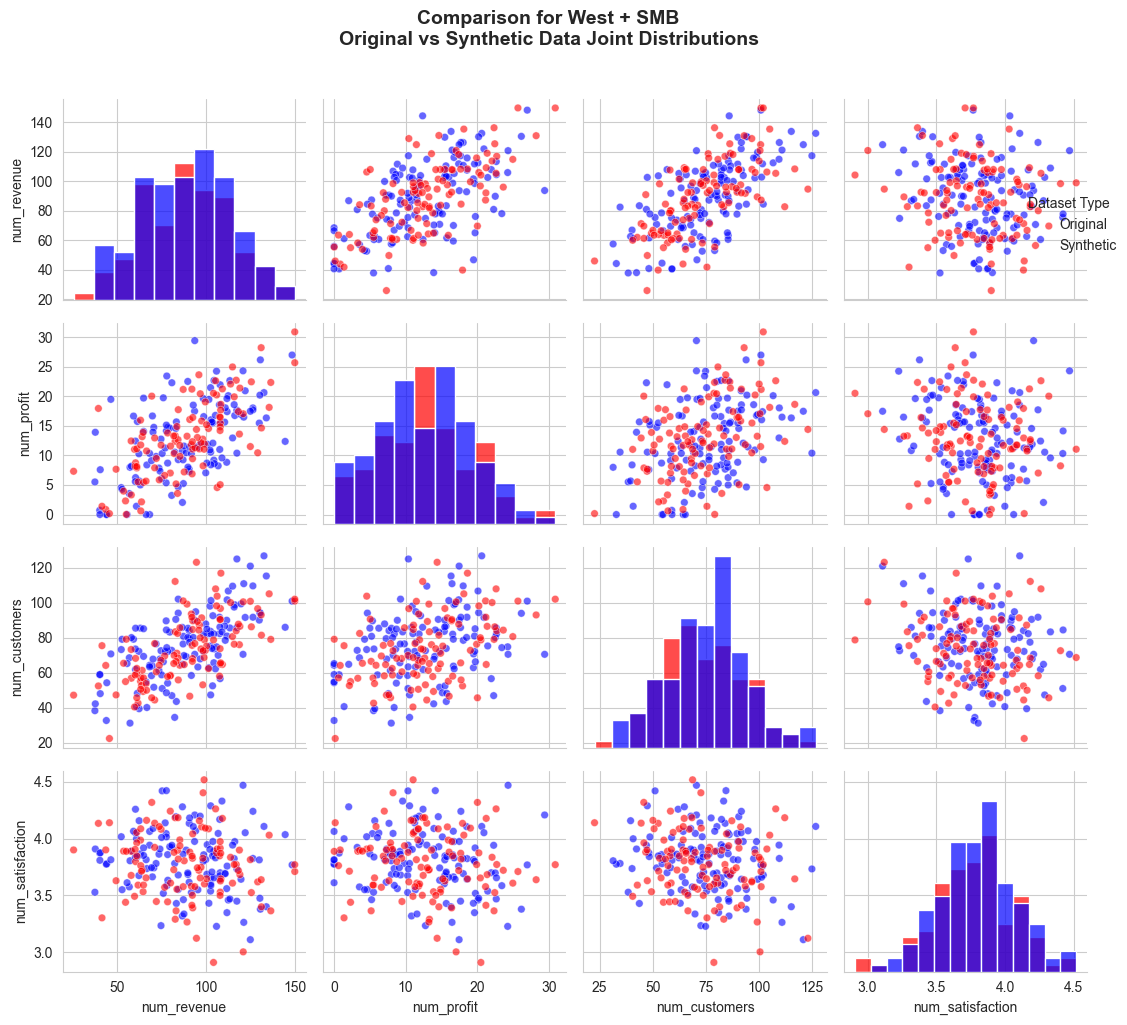

  📈 Statistics for West + SMB:
    num_revenue: Orig(μ=89.03, σ=24.70) vs Synth(μ=88.57, σ=24.97)
    num_profit: Orig(μ=12.68, σ=6.51) vs Synth(μ=12.92, σ=6.51)
    num_customers: Orig(μ=75.75, σ=19.51) vs Synth(μ=73.63, σ=19.00)
    num_satisfaction: Orig(μ=3.81, σ=0.27) vs Synth(μ=3.78, σ=0.29)
    Correlation preservation quality:
    Average correlation difference: 0.053
  ✅ Completed pair plot for West + SMB

🎊 ALL CATEGORY-WISE PAIR PLOTS COMPLETED!
Review the plots above to see how well joint distributions were preserved for each category combination.


In [10]:
def create_category_wise_pairplots(original_df, synthetic_df, cat_cols, num_cols):
    """Create individual pair plots for each categorical combination"""
    
    print(f"🎨 CREATING CATEGORY-WISE PAIR PLOTS")
    print(f"{'='*60}")
    
    # Get all unique combinations
    unique_combinations = original_df.groupby(cat_cols).size().index.tolist()
    
    for i, combination in enumerate(unique_combinations):
        print(f"\n📊 Creating pair plot {i+1}/{len(unique_combinations)}: {combination}")
        
        # Filter data for this combination
        if len(cat_cols) == 1:
            orig_subset = original_df[original_df[cat_cols[0]] == combination]
            synth_subset = synthetic_df[synthetic_df[cat_cols[0]] == combination]
        else:
            # Multiple categorical columns
            orig_mask = True
            synth_mask = True
            for j, col in enumerate(cat_cols):
                orig_mask &= (original_df[col] == combination[j])
                synth_mask &= (synthetic_df[col] == combination[j])
            orig_subset = original_df[orig_mask]
            synth_subset = synthetic_df[synth_mask]
        
        if len(orig_subset) == 0 or len(synth_subset) == 0:
            print(f"  ⚠️  Skipping {combination}: insufficient data")
            continue
        
        print(f"  Original samples: {len(orig_subset)}, Synthetic samples: {len(synth_subset)}")
        
        # Prepare data for plotting
        orig_plot = orig_subset[num_cols].copy()
        orig_plot['Dataset'] = 'Original'
        
        synth_plot = synth_subset[num_cols].copy()
        synth_plot['Dataset'] = 'Synthetic'
        
        # Combine for overlay plotting
        combined_plot = pd.concat([orig_plot, synth_plot], ignore_index=True)
        
        # Create pair plot
        g = sns.pairplot(
            combined_plot,
            hue='Dataset',
            diag_kind='hist',
            plot_kws={'alpha': 0.6, 's': 30},
            diag_kws={'alpha': 0.7},
            height=2.5,
            palette=['blue', 'red']
        )
        
        # Customize the plot
        combination_str = str(combination) if len(cat_cols) == 1 else ' + '.join(map(str, combination))
        g.fig.suptitle(
            f'Comparison for {combination_str}\nOriginal vs Synthetic Data Joint Distributions',
            y=1.02, fontsize=14, fontweight='bold'
        )
        
        # Improve legend
        g._legend.set_title('Dataset Type')
        g._legend.set_bbox_to_anchor((1.02, 0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics for this combination
        print(f"  📈 Statistics for {combination_str}:")
        
        for col in num_cols:
            orig_mean = orig_subset[col].mean()
            synth_mean = synth_subset[col].mean()
            orig_std = orig_subset[col].std()
            synth_std = synth_subset[col].std()
            
            print(f"    {col}: Orig(μ={orig_mean:.2f}, σ={orig_std:.2f}) vs Synth(μ={synth_mean:.2f}, σ={synth_std:.2f})")
        
        # Correlation comparison for this group
        if len(num_cols) > 1:
            orig_corr = orig_subset[num_cols].corr()
            synth_corr = synth_subset[num_cols].corr()
            
            print(f"    Correlation preservation quality:")
            corr_diff = abs(orig_corr - synth_corr).values
            avg_corr_diff = np.mean(corr_diff[np.triu_indices_from(corr_diff, k=1)])
            print(f"    Average correlation difference: {avg_corr_diff:.3f}")
        
        print(f"  ✅ Completed pair plot for {combination_str}")
    
    print(f"\n🎊 ALL CATEGORY-WISE PAIR PLOTS COMPLETED!")
    print(f"Review the plots above to see how well joint distributions were preserved for each category combination.")

# Create the category-wise pair plots
create_category_wise_pairplots(df, synthetic_df, cat_cols, num_cols)

## Step 10: Save Results and Summary

In [11]:
# Save datasets
df.to_csv('original_dataset.csv', index=False)
synthetic_df.to_csv(f'synthetic_dataset_{GENERATION_METHOD}.csv', index=False)

print(f"💾 SAVED FILES:")
print(f"- original_dataset.csv")
print(f"- synthetic_dataset_{GENERATION_METHOD}.csv")

# Save detailed analysis
analysis_summary = {
    'original_shape': df.shape,
    'synthetic_shape': synthetic_df.shape,
    'categorical_columns': cat_cols,
    'numerical_columns': num_cols,
    'generation_method': GENERATION_METHOD,
    'unique_combinations': len(df.groupby(cat_cols)),
    'distributions_fitted': len(synthesizer.distributions)
}

with open(f'analysis_summary_{GENERATION_METHOD}.txt', 'w') as f:
    f.write("Joint Distribution Analysis Summary\n")
    f.write("=" * 40 + "\n\n")
    for key, value in analysis_summary.items():
        f.write(f"{key}: {value}\n")

print(f"- analysis_summary_{GENERATION_METHOD}.txt")

# Final comprehensive summary
print(f"\n{'='*70}")
print(f"🎯 JOINT DISTRIBUTION ANALYSIS - FINAL SUMMARY")
print(f"{'='*70}")

print(f"📊 DATA OVERVIEW:")
print(f"   Original dataset: {df.shape[0]:,} samples, {df.shape[1]} features")
print(f"   Synthetic dataset: {synthetic_df.shape[0]:,} samples, {synthetic_df.shape[1]} features")
print(f"   Categorical columns: {len(cat_cols)} ({', '.join(cat_cols)})")
print(f"   Numerical columns: {len(num_cols)} ({', '.join(num_cols)})")

print(f"\n🔧 METHODOLOGY:")
print(f"   Generation method: {GENERATION_METHOD}")
print(f"   Unique categorical combinations: {len(df.groupby(cat_cols))}")
print(f"   Joint distributions fitted: {len(synthesizer.distributions)}")
print(f"   Minimum samples per group: 5")

print(f"\n📈 VALIDATION PERFORMED:")
print(f"   ✅ Overall statistical comparison (means, std devs)")
print(f"   ✅ Group-wise statistical comparison")
print(f"   ✅ Correlation matrix comparison")
print(f"   ✅ Overall pair plots (original vs synthetic)")
print(f"   ✅ Category-wise pair plots (each combination)")

print(f"\n🎊 ANALYSIS COMPLETE!")
print(f"\n💡 KEY INSIGHTS:")
print(f"   • Joint distributions were constructed for each categorical combination")
print(f"   • Synthetic data preserves statistical relationships within each group")
print(f"   • Pair plots show visual validation of distribution preservation")
print(f"   • Method '{GENERATION_METHOD}' was used for generation")

print(f"\n🔄 TO USE WITH DIFFERENT SETTINGS:")
print(f"   • Change DESIRED_SYNTHETIC_SIZE at the top")
print(f"   • Try different GENERATION_METHOD: 'multivariate_normal', 'kde', 'bootstrap'")
print(f"   • Update CSV_FILE_PATH to your data file")

print(f"\n📝 REMEMBER:")
print(f"   • Ensure your CSV has 'cat_' and 'num_' prefixed columns")
print(f"   • Review category-wise pair plots for quality assessment")
print(f"   • Multivariate normal works best for Gaussian-like data")
print(f"   • KDE is more flexible for non-Gaussian distributions")
print(f"   • Bootstrap preserves exact empirical distributions")

print(f"{'='*70}")

💾 SAVED FILES:
- original_dataset.csv
- synthetic_dataset_multivariate_normal.csv
- analysis_summary_multivariate_normal.txt

🎯 JOINT DISTRIBUTION ANALYSIS - FINAL SUMMARY
📊 DATA OVERVIEW:
   Original dataset: 1,200 samples, 6 features
   Synthetic dataset: 997 samples, 6 features
   Categorical columns: 2 (cat_region, cat_segment)
   Numerical columns: 4 (num_revenue, num_profit, num_customers, num_satisfaction)

🔧 METHODOLOGY:
   Generation method: multivariate_normal
   Unique categorical combinations: 12
   Joint distributions fitted: 12
   Minimum samples per group: 5

📈 VALIDATION PERFORMED:
   ✅ Overall statistical comparison (means, std devs)
   ✅ Group-wise statistical comparison
   ✅ Correlation matrix comparison
   ✅ Overall pair plots (original vs synthetic)
   ✅ Category-wise pair plots (each combination)

🎊 ANALYSIS COMPLETE!

💡 KEY INSIGHTS:
   • Joint distributions were constructed for each categorical combination
   • Synthetic data preserves statistical relationships 